<div style="width: 100%; overflow: hidden; text-align:center;">
    <h1>INF-477 Redes Neuronales Artificiales</h1>
    <h2>Tarea 2 - Autoencoders, RBMs y ConvNets</h2><br/>
    <div style="width: 50%; float: left;">
        <h3>Gabriel Jara</h3>
        <h4>``gabriel.jara@usm.cl``</h4>
        <h4>13550188-3</h4>
    </div>
    <div style="margin-left: 300px;">
        <h3>Daniel San Martín</h3>
        <h4>``daniel.sanmartinr@sansano.usm.cl``</h4>
        <h4>682016101-5</h4>
    </div>
</div>

## 1 Entrenamiento de Autoencoders (AEs) y RBMs en MNIST

Como hemos discutido en clases, las RBM’s y posteriormente los AE’s, fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar estos modelos en tres escenarios clásicos: reducción de dimensionalidad, denoising y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado
MNIST, bastante conocido en el área e introducido por Yann LeCunn hacia 1998 [7] en un trabajo que, junto al Neocognitron de Fukushima [8], se considera uno de los principales antecedentes de las redes convolucionales modernas. Se trata de una colecciión de 70.000 imágenes de 28 × 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60.000 imágenes y otro de test de 10.000 imágenes. La tarea consiste en entrenar un programa para que aprenda a identificar correctamente el dígito representado en la imagen.

<img width="70%" src="img/figure1.png">
<center>Fig. 1: Dataset MNIST y visualización obtenida usando las primeras dos componentes principales.</center>

(a) Escriba una función que cargue los datos desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en $[0, 1]$, transforme las imágenes en vectores ($\in \mathbb{R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. La normalización permite interpretar cada valor como una probabilidad de "activación" del un pixel. El conjunto de pruebas será aquel por defecto. Para la construcción del subconjunto de validación su función recibirá un parámetro NVAL, cuyo valor por defecto será $1000$. El conjunto de validación se construirá utilizando
los últimos nval casos del conjunto del entrenamiento por defecto. El conjunto de entrenamiento consistirá en las primeras 60000 − NVAL imágenes.

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np

# Carga de datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizacion de imagenes
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Transformacion en vectores R^{784}
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Creacion conjunto de validacion
nval = 1000
x_val = x_train[-nval:]
y_val = y_train[-nval:]
x_train = x_train[:-nval]
y_train = y_train[:-nval]

# Transformacion a probabilidades de activacion
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### 1.1 Reducción de Dimensionalidad

Construir una representación de menor dimensionalidad de un objeto en $\mathbb{R}^d$, consiste en construir una función $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^{d'}$, con $d'<<d$ que preserve lo mejor posible la "información" original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadístico (permite construir modelos con un
menor número de parámetros libres). Una técnica de reducción de dimensionalidad se denomina no supervisada cuando no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento, marco de trabajo útil cuando dicha información no está disponible. Un AE y una RBM se pueden considerar métodos no-supervisados de reducción de dimensionalidad.

Se define a continuación el error de reconstrucción con que se evaluará todos los modelos que se presente, correspondiente al Error Cuadrático. Se consideró la posibilidad de utilizar Binary Cross Entropy, que de hecho es la función loss que con que se entrena los modelos, dado que los datos se presentan entre 0 y 1. Sin embargo, por generalidad, y ante la posibilidad de que algunos modelos no necesariamente sean alimentados estrictamente con datos en dicho tramo (por ejemplo por efecto de ruido), se ha optado por el Error Cuadrático. Cabe señalar que este Error de Recostrucción es sólo para efectos de evaluación de modelos, y no interviene durante el aprendizaje.  

In [3]:
# Error de Reconstrucción R2

def error_reconstruccion(x_test, x_decoded_test):
 
    error_reco = 0
    for l in range(len(x_test)): # para cada vector de prueba
        error = 0
        for i in range(len(x_test[0])): # para cada salida
            error += (x_test[l,i] - x_decoded_test[l,i])**2
    error_reco += error
    return error_reco/len(x_test)
    

In [4]:
def clustering_accuracy(pred_labels,y,nclusters=10):
    true_pred = 0.0
    for i in range(0,nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)
  

(a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d' = 2, 8, 32, 64$ dimensiones. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación ReLU para el Encoder? ¿Podría utilizarse una ReLU en el decoder?

Se aprecia en los dos modelos que se presenta a continuación, que efectivamente la función de activación incide de manera importante. ReLu disminuye el error de reconstrucción a la mitad, respecto a sigmoid. A su vez, en ambos modelos la representación mejora al aumentar el número de capas. 

Respecto a utilizar ReLu en como activación en la fase de reconstrucción, citamos a Glorot, Bordes y Bengio (Deep Sparse Rectifier Neural Networks" (pag 5): "... la saturación inferior de la función de rectificación no es adecuada para la unidad de reconsrucción. De hecho, siempre que circunstancialmente la red reconstruye un cero en el lugar de un valor objetivo no cero, la unidad de reconstrucción no puede propagar ningún gradiente". Se pudo constatar que efectivamente utilizar ReLu como función de activación en el decoder impactó negativamente en el error de reconstrucción, pero no se presenta el modelo por razones de tiempo y volúmen. 

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

input_img = Input(shape=(784,))

# Dimensiones
dim = np.array([2, 8, 32, 64])

# Para guardar los modelos
autoencoder = [None]*4
encoder = [None]*4
decoder = [None]*4
encoded_test = [None]*4
decoded_test = [None]*4
scores = np.empty(4)

for i in range(4):
    # AE para cada dimension
    encoded = Dense(dim[i], activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder[i] = Model(input=input_img, output=decoded)
    encoder[i] = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim[i],))
    decoder_layer = autoencoder[i].layers[-1]
    decoder[i] = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder[i].fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, #nb_epoch=50, batch_size=25 OJO
                    verbose=0,validation_data=(x_val, x_val))
    encoded_test[i] = encoder[i].predict(x_test)
    decoded_test[i] = decoder[i].predict(encoded_test[i])
    #scores[i] = autoencoder[i].evaluate(decoded_test[i], x_test, verbose=0)
    error = error_reconstruccion(x_test, decoded_test[i])
    print "d'= " + str(dim[i])
    print "Porcentaje de compresion: " + str(float(dim[i])*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print ''
    autoencoder[i].save('basic_autoencoder_768x' + str(dim[i]) + '.h5')

d'= 2
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00777017386339

d'= 8
Porcentaje de compresion: 1.02040816327 %
Error de reconstruccion: 0.00684265787905

d'= 32
Porcentaje de compresion: 4.08163265306 %
Error de reconstruccion: 0.00358024186118

d'= 64
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.00191571891067



In [5]:
# IDEM pero con ReLu
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

input_img = Input(shape=(784,))

# Dimensiones
dim = np.array([2, 8, 32, 64])

# Para guardar los modelos
r_autoencoder = [None]*4
r_encoder = [None]*4
r_decoder = [None]*4
r_encoded_test = [None]*4
r_decoded_test = [None]*4
r_scores = np.empty(4)

for i in range(4):
    # AE para cada dimension
    encoded = Dense(dim[i], activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    r_autoencoder[i] = Model(input=input_img, output=decoded)
    r_encoder[i] = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim[i],))
    decoder_layer = r_autoencoder[i].layers[-1]
    r_decoder[i] = Model(input=encoded_input, output=decoder_layer(encoded_input))
    r_autoencoder[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    r_autoencoder[i].fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, #nb_epoch=50, batch_size=25
                    verbose=0,validation_data=(x_val, x_val))
    r_encoded_test[i] = r_encoder[i].predict(x_test)
    r_decoded_test[i] = r_decoder[i].predict(r_encoded_test[i])
    #scores[i] = autoencoder[i].evaluate(decoded_test[i], x_test, verbose=0)
    error = error_reconstruccion(x_test, r_decoded_test[i])
    print "d'= " + str(dim[i])
    print "Porcentaje de compresion: " + str(float(dim[i])*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print ''
    r_autoencoder[i].save('relu_basic_autoencoder_768x' + str(dim[i]) + '.h5')

d'= 2
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00602387672686

d'= 8
Porcentaje de compresion: 1.02040816327 %
Error de reconstruccion: 0.00265312563778

d'= 32
Porcentaje de compresion: 4.08163265306 %
Error de reconstruccion: 0.00126877182842

d'= 64
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.000435400948575



(b) Para verificar la calidad del modelo obtenido, compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en $\mathbb{R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observado. Comente.

Al observar las imágenes reconstruidas a continuación, queda claro que el error de reconstrucción representa bastante la realidad de la imagen. Se aprecia como la representación se aclara al aumentar las dimensiones. También se observa que ReLu es más exitoso que sigmoid. 

(10000, 2)
Reconstruccion para d'=2


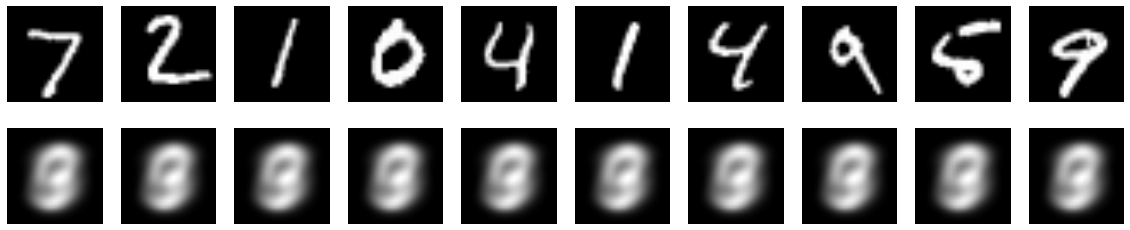

(10000, 8)
Reconstruccion para d'=8


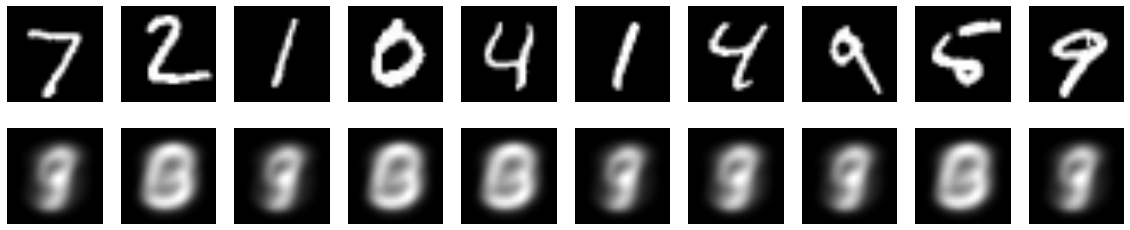

(10000, 32)
Reconstruccion para d'=32


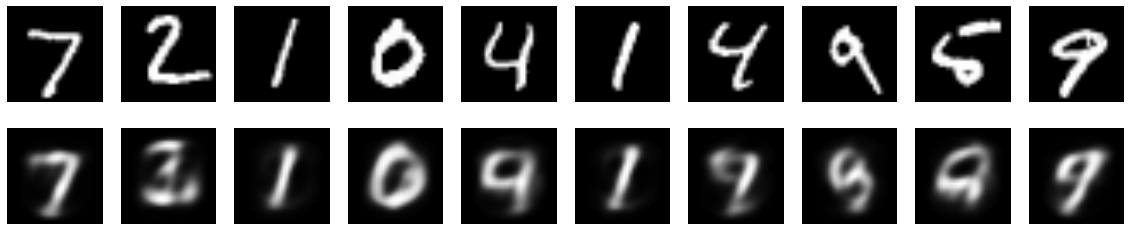

(10000, 64)
Reconstruccion para d'=64


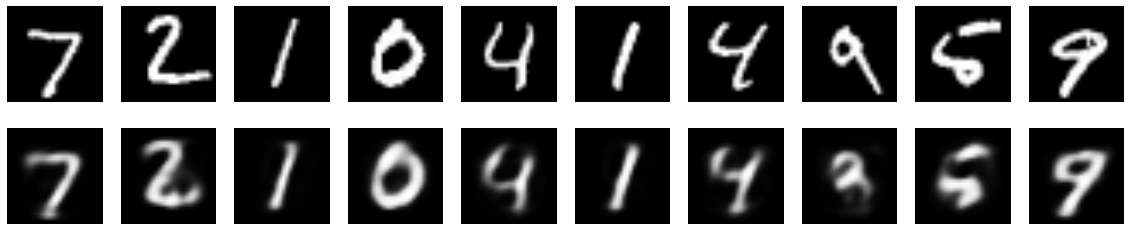

In [6]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

for j in range(4):
    autoencoder = load_model('basic_autoencoder_768x' + str(dim[j]) + '.h5')

    encoded_test = encoder[j].predict(x_test)
    decoded_test = decoder[j].predict(encoded_test)
    print(encoded_test.shape)

    # plots
    n = 10
    plt.figure(figsize=(20, 4))
    
    print "Reconstruccion para d'=" + str(dim[j])
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(10000, 2)
Reconstruccion para d'=2


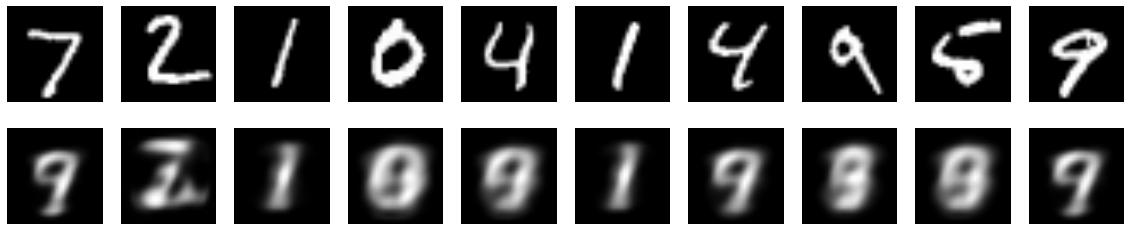

(10000, 8)
Reconstruccion para d'=8


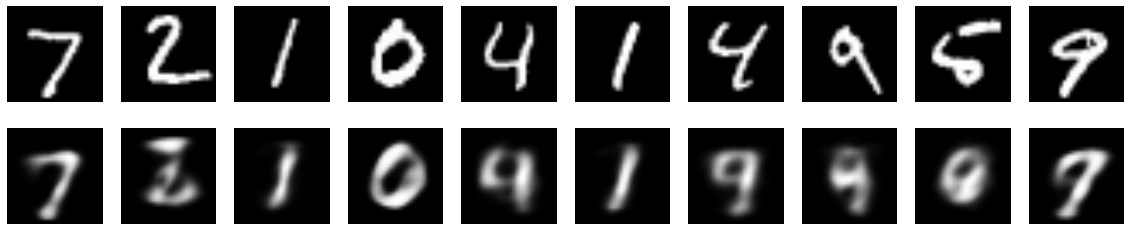

(10000, 32)
Reconstruccion para d'=32


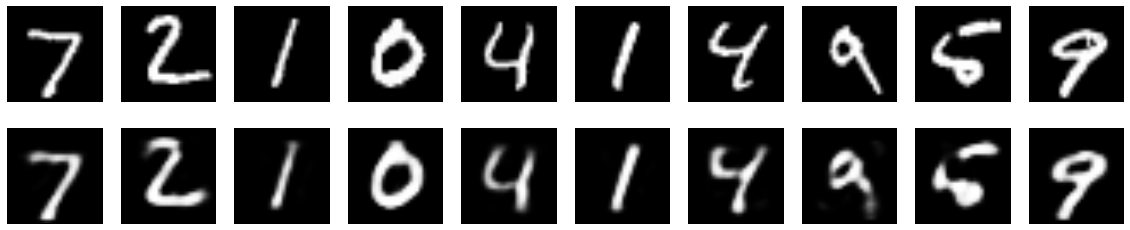

(10000, 64)
Reconstruccion para d'=64


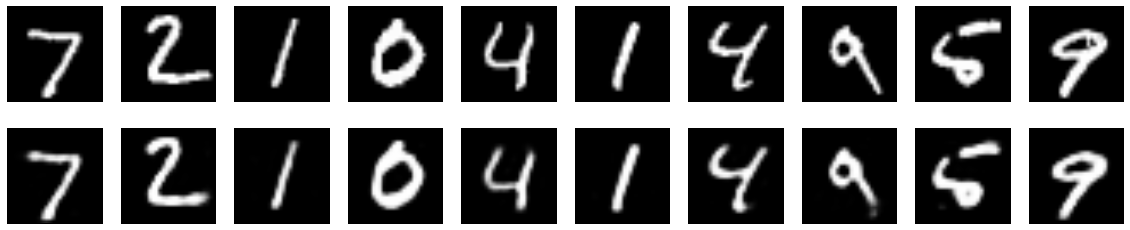

In [7]:
#IDEM pero con ReLu

from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

for j in range(4):
    autoencoder = load_model('relu_basic_autoencoder_768x' + str(dim[j]) + '.h5')
    encoded_test = r_encoder[j].predict(x_test)
    decoded_test = r_decoder[j].predict(encoded_test)
    print(encoded_test.shape)

    # plots
    n = 10
    plt.figure(figsize=(20, 4))
    
    print "Reconstruccion para d'=" + str(dim[j])
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(c) Para verificar la calidad de la representación obtenida, implemente el siguiente clasificador, denominado $kNN$ (k-nearest neighbor): dada una imagen $\textbf{x}$, el clasificador busca las $k = 10$ imágenes de entrenamiento más similares $N_{\textbf{x}} = \{\textbf{x}^{(k_i)}\}^{10}_{i=1}$ (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes $N_x$. Mida el error de pruebas obtenido construyendo este clasificador sobre la data original y luego sobre la data reducida. Compare además los tiempos medios de predicción en ambos escenarios.

Se procede a continuacipón a clasificar las representaciones obtenidas utilizando kNN. Dado que se trata de un algoritmo de aprendizaje supervisado, es necesario utilizar las equiquetas durante el entrenamiento. Se presenta la exactitud de la clasificación. Se observa que si bien ambas funciones de activación llegan a un nivel igualmente alto de exactitud con varias dimensiones, ReLu mejora más rápido que sigmoid al agregar dimensiones. 

In [8]:
encoded_train = [None]*4 # guardar el conjunto encoded de entrenamiento

# para cada representacion
for i in range(4):
    encoded_train[i] = encoder[i].predict(x_train) # Conjunto encoded de entrenamiento
    encoded_test = encoder[i].predict(x_test) # Conjunto encoded de testing
    
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train[i], y_train)
    score = clf.score(encoded_test,y_test)
    
    print "Representacion para d'=" + str(dim[i]) + ":"
    print 'Classification Accuracy %.2f' % score + "\n"

Representacion para d'=2:
Classification Accuracy 0.18

Representacion para d'=8:
Classification Accuracy 0.31

Representacion para d'=32:
Classification Accuracy 0.90

Representacion para d'=64:
Classification Accuracy 0.96



In [9]:
# IDEM pero ReLu

r_encoded_train = [None]*4 # guardar el conjunto encoded de entrenamiento

# para cada representacion
for i in range(4):
    r_encoded_train[i] = r_encoder[i].predict(x_train) # Conjunto encoded de entrenamiento
    encoded_test = r_encoder[i].predict(x_test) # Conjunto encoded de testing
    
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(r_encoded_train[i], y_train)
    score = clf.score(encoded_test,y_test)
    
    print "Representacion para d'=" + str(dim[i]) + ":"
    print 'Classification Accuracy %.2f' % score + "\n"

Representacion para d'=2:
Classification Accuracy 0.42

Representacion para d'=8:
Classification Accuracy 0.89

Representacion para d'=32:
Classification Accuracy 0.97

Representacion para d'=64:
Classification Accuracy 0.96



(d) Para verificar la calidad de la representación obtenida, implemente $k-means$ (un método básico de agrupamiento) sobre la representación obtenida por el autoencoder. Mida la calidad del agrupamiento obtenido sobre los datos reducidos utilizando la métrica denominada ARI (*Adjusted Rand Index*) y la función de desempeño (que llamaremos *clustering accuracy*) definida el código de ejemplo que se proporciona más abajo. Compare el resultado con el agrupamiento obtenido sobre los datos originales.

A continuación se agrupa las representaciones utilizando k-means. Al ser un algoritmo de aprendizaje no supervizado no necesita las etiquetas para generar los cluster. Sin emabargo, para calcular la exactitud (ACC) sí se recurre a las etiquetas. Se presenta también el grado de ajuste entre grupos (ARI), esta última medida no supervizada. Es interesante constatar que pese a que ReLu supera a Sigmoid en todos los otros parámetros de evaluación, no es el caso en la evaluación de agrupamiento, donde sigmoid tiene mejor desempeño, siempre que cuente con suficientes dimensiones en la capa oculta. 

In [10]:
from sklearn.cluster import KMeans
from sklearn import metrics

for i in range(4): # para cada representacion
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(encoded_train[i])
    score = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Representacion para d'=" + str(dim[i])
    print 'Clustering ARI %.2f' % score
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print ""

Representacion para d'=2
Clustering ARI 0.00
Clustering ACC 0.12

Representacion para d'=8
Clustering ARI 0.12
Clustering ACC 0.27

Representacion para d'=32
Clustering ARI 0.32
Clustering ACC 0.54

Representacion para d'=64
Clustering ARI 0.43
Clustering ACC 0.64



In [11]:
# IDEM pero ReLu
def clustering_accuracy(pred_labels,y,nclusters=10):
    true_pred = 0.0
    for i in range(0,nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)

for i in range(4): # para cada representacion
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(r_encoded_train[i])
    score = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Representacion para d'=" + str(dim[i])
    print 'Clustering ARI %.2f' % score
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print ""

Representacion para d'=2
Clustering ARI 0.21
Clustering ACC 0.41

Representacion para d'=8
Clustering ARI 0.28
Clustering ACC 0.50

Representacion para d'=32
Clustering ARI 0.22
Clustering ACC 0.43

Representacion para d'=64
Clustering ARI 0.23
Clustering ACC 0.43



(e) $\star$ Compare la calidad de la representación reducida obtenida por el autoencoder básico con aquella obtenida vía PCA utilizando el mismo número de dimensiones $d'$. Considere los 4 criterios que hemos utilizado hasta el momento, i.e., error de reconstrucción, visualización de la reconstrucción, desempeño en clasificación (vía kNN) y desempeño en agrupamiento (vía kMeans). Comente.

PCA es equivalente a un autoncoder lineal, y como tal logra resultados similares. En este caso se aprecia que para los distintos números de dimensiones explorados, en general logró error de reconstrucción e indicadores mejores que AE con sigmoid, pero quedó por debajo del desempeño de ReLu. También es interesante observar que las imágenes reconstruidas con PCA presentan distorciones particuales, quizá relacionadas con la linealidad del modelo. 

In [12]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

pca = [None]*4 # guardar modelos PCA
pca_train = [None]*4 # Guardar PCA train
pca_test = [None]*4 # Guardar PCA test
pca_decoded = [None]*4

for i in range(4): # para cada dimension d'
    pca[i] = PCA(n_components=dim[i])
    pca[i].fit(x_train)
    pca_train[i] = pca[i].transform(x_train)
    pca_test[i] = pca[i].transform(x_test)
    pca_decoded[i] = pca[i].inverse_transform(pca_test[i])
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train[i], y_train)
    score = clf.score(pca_test[i],y_test)
    error = error_reconstruccion(x_test, pca_decoded[i])
    # k-means
    model = KMeans(n_clusters=10)    
    labels_pred = model.fit_predict(pca_train[i])
    scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Representacion para d'=%.d" % dim[i]
    print "Porcentaje de compresion: " + str(float(dim[i])*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print 'Classification Accuracy %.2f' % score
    print 'Clustering ARI %.2f' % scorekMeans
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print ''

Representacion para d'=2
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00609895649897
Classification Accuracy 0.44
Clustering ARI 0.23
Clustering ACC 0.41

Representacion para d'=8
Porcentaje de compresion: 1.02040816327 %
Error de reconstruccion: 0.00279798669894
Classification Accuracy 0.90
Clustering ARI 0.35
Clustering ACC 0.59

Representacion para d'=32
Porcentaje de compresion: 4.08163265306 %
Error de reconstruccion: 0.00189650173941
Classification Accuracy 0.97
Clustering ARI 0.36
Clustering ACC 0.59

Representacion para d'=64
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.0010229294537
Classification Accuracy 0.97
Clustering ARI 0.36
Clustering ACC 0.58



Reconstruccion para d'=2


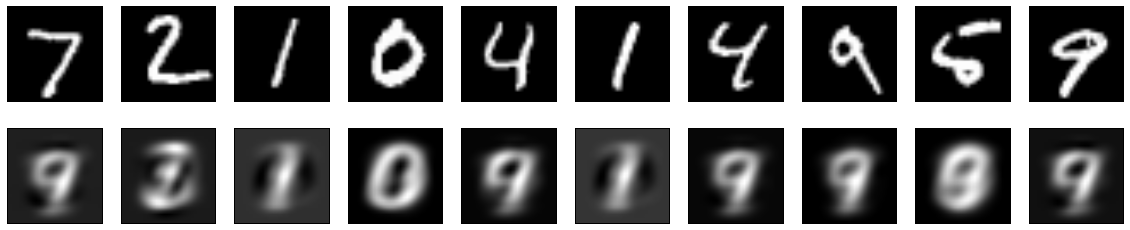

Reconstruccion para d'=8


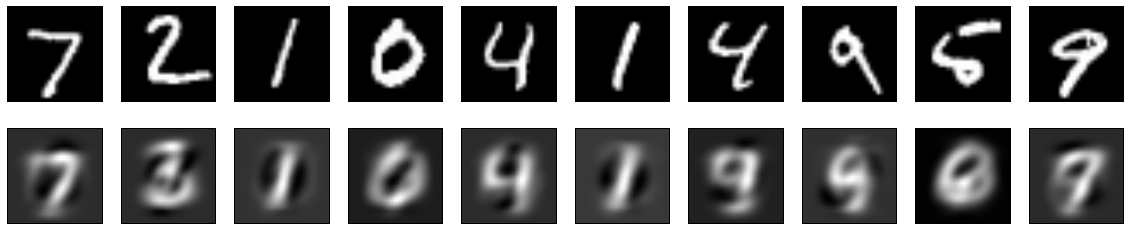

Reconstruccion para d'=32


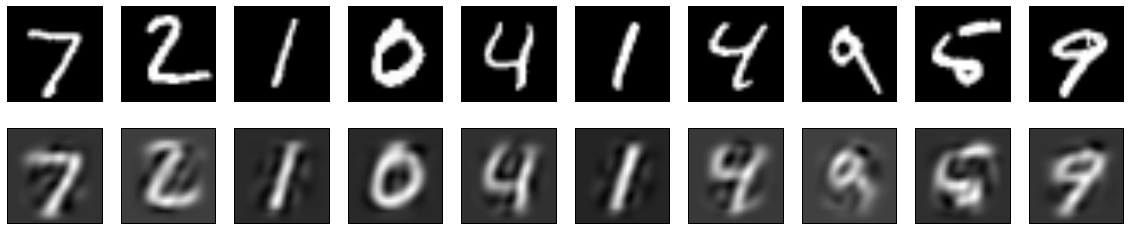

Reconstruccion para d'=64


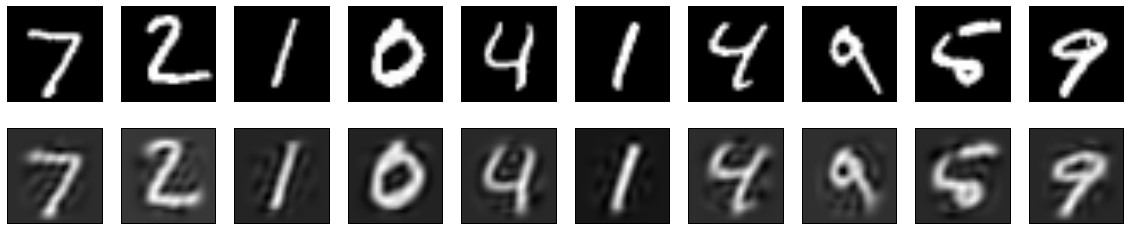

In [16]:
# Visualizacion
#from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

for j in range(4):
    # Reconstruccion de imagen por PCA
    decoded_test = pca_decoded[j]

    # plots
    n = 10
    plt.figure(figsize=(20, 4))
    
    print "Reconstruccion para d'=" + str(dim[j])
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(f) Entrene una RBM binaria básica para generar una representación de MNIST en $d' = 2, 8, 32, 64$ dimensiones. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. Compare con los resultados obtenidos por el autoencoder utilizando los 3 criterios que hemos utilizado hasta el momento, i.e., error de reconstrucción, desempeño en clasificación (vía kNN) y desempeño en agrupamiento (vía kMeans)†.

Se procede a continuación a implementar una RBM binaria. Se aprecia que los resultados en general no superan los de PCA, respecto a error de reconstrucción, ni por exactitud de clasificación. Sí pareciera tener mejor agrupamiento que PCA. 

Al observar las imágenes reconstruidas salta a la vista el caracter binario de las unidades que componen esta red. 

In [17]:
from sklearn.neural_network import BernoulliRBM
import numpy as np
import pickle ##to save trained models

rbm = [None]*4 # guardar modelos RBM
rbm_train = [None]*4 # Guardar RBM train
rbm_test = [None]*4 # Guardar RBM test
decoded_rbm_test = [None]*4

for i in range(4): # para cada d'
    rbm[i] = BernoulliRBM(n_components=dim[i], batch_size=25, learning_rate=0.05,verbose=0, n_iter=50) ##n_components is d'
    rbm[i].fit(x_train) ##Train using persistent Gibbs chains
    rbm_train[i] = rbm[i].transform(x_train)
    rbm_test[i] = rbm[i].transform(x_test)
    decoded_rbm_test[i] = rbm[i].gibbs(x_test)
    
    clf = KNeighborsClassifier(10)
    clf.fit(rbm_train[i], y_train)
    score = clf.score(rbm_test[i],y_test)
    error = error_reconstruccion(x_test, decoded_rbm_test[i])
    # k-means
    model = KMeans(n_clusters=10)    
    labels_pred = model.fit_predict(rbm_train[i])
    scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Representacion para d'=%.d" % dim[i]
    print "Porcentaje de compresion: " + str(float(dim[i])*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print 'Classification Accuracy %.2f' % score
    print 'Clustering ARI %.2f' % scorekMeans
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print ''
    fileo = open('basicRBM' + str(dim[i]) + '.pickle','wb')
    pickle.dump(model,fileo)
    fileo.close()
    

Representacion para d'=2
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.0143674879621
Classification Accuracy 0.36
Clustering ARI 0.19
Clustering ACC 0.33

Representacion para d'=8
Porcentaje de compresion: 1.02040816327 %
Error de reconstruccion: 0.0138843507381
Classification Accuracy 0.51
Clustering ARI 0.06
Clustering ACC 0.21

Representacion para d'=32
Porcentaje de compresion: 4.08163265306 %
Error de reconstruccion: 0.00661964480772
Classification Accuracy 0.92
Clustering ARI 0.43
Clustering ACC 0.64

Representacion para d'=64
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.00596238988048
Classification Accuracy 0.96
Clustering ARI 0.47
Clustering ACC 0.67



Reconstruccion para d'=2


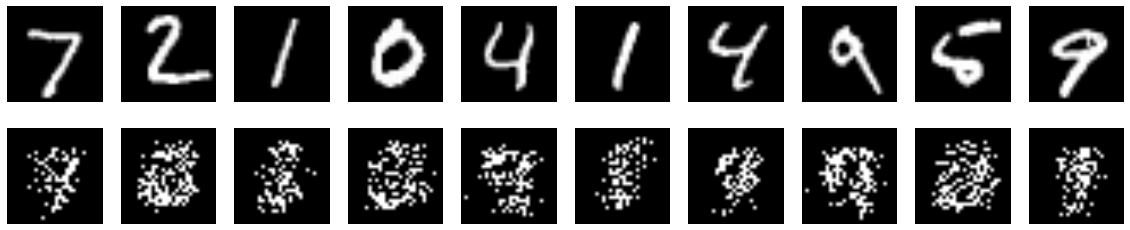

Reconstruccion para d'=8


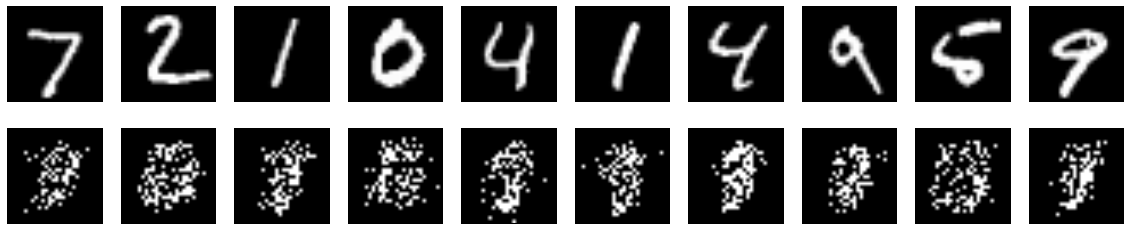

Reconstruccion para d'=32


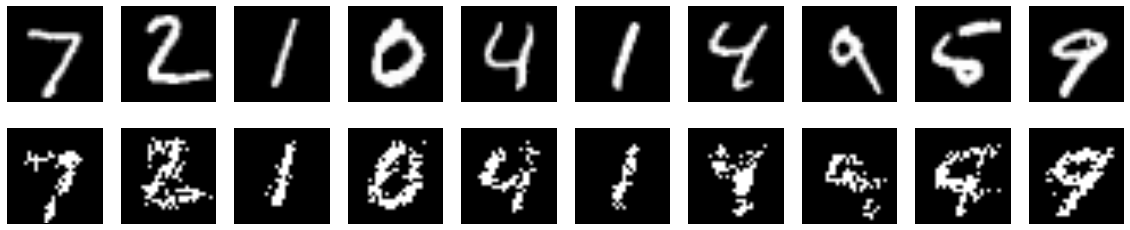

Reconstruccion para d'=64


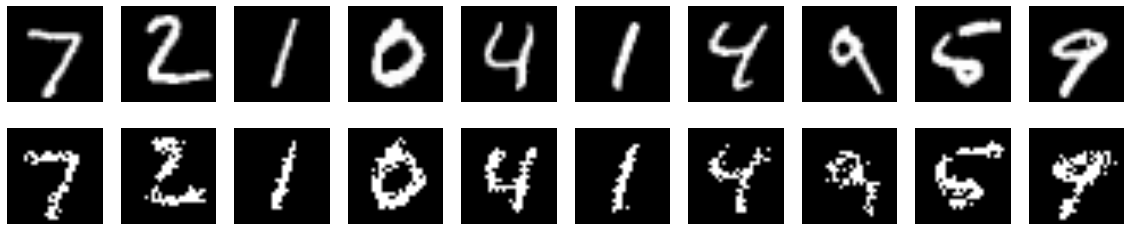

In [18]:
# Visualizacion
#from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

for j in range(4):
    # Reconstruccion de imagen por RBM
    decoded_test = decoded_rbm_test[j] 

    # plots
    n = 10
    plt.figure(figsize=(20, 4))
    
    print "Reconstruccion para d'=" + str(dim[j])
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(g) $\star\star$ Modifique el autoencoder básico construido en (a) para implementar un *deep autoencoder* (deep AE), es decir, un autoencoder con al menos dos capas ocultas. Demuestre experimentalmente que este autoencoder puede mejorar significativamente la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$. Experimente con $d' = 2, 4, 8, 16, 32$ y distintas profundidades $(L = 2, 3, 4)$.
Considere en esta comparación los 3 criterios que hemos utilizado hasta el momento, i.e., error de reconstrucción, desempeño en clasificación (vía kNN) y desempeño en agrupamiento (vía kMeans). Comente.

Se entrena un conjunto de deep AE, para cada uno de los cuales se presenta las métricas de evaluación. Además se implementa PCA con el mismo número de dimensiones que la capa intermedia, para efectos de comparación.

Con sólo 2 dimensiones (en la capa intermedia) se observa que aumentar el número de capas no garantiza disminuir el error, siendo el error con tres capas mayor que con dos capas. Se puede especular que dos unidades en la capa intermedia es un cuello de botella demasiado estrecho para permitir un correcto aprendizaje, independiente del número de capas que se agregue. En cualquier caso, con 2, 3 y 4 capas siempre se supero PCA, en cuanto a error. 

Ya a partir de 4 dimensiones intermedias se observa que aumentar el número de capas disminuye consistentemente el error de reconstrucción. En general, al incorporar la cuarta capa oculta se produce una fuerte caída del error, mayor que la observada al incorporar las dos capas previas. 



In [19]:
input_img = Input(shape=(784,))

import numpy

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

autoencoder4 = [None]*5
autoencoder3 = [None]*5
autoencoder2 = [None]*5
encoder4 = [None]*5
encoder3 = [None]*5
encoder2 = [None]*5
decoded_test4 = [None]*5
decoded_test3 = [None]*5
decoded_test2 = [None]*5
encoded_test4 = [None]*5
encoded_test3 = [None]*5
encoded_test2 = [None]*5
encoded_train4 = [None]*5
encoded_train3 = [None]*5
encoded_train2 = [None]*5

pca = [None]*5 
pca_train = [None]*5 
pca_test = [None]*5  
pca_decoded = [None]*5

for i in range(5):
    target_dim = 2**(i+1)
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(250, activation='relu')(encoded2)
    encoded4 = Dense(target_dim, activation='relu')(encoded3)
    decoded4 = Dense(250, activation='relu')(encoded4)
    decoded3 = Dense(500, activation='relu')(encoded3)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder4[i] = Model(input=input_img, output=decoded1)
    encoder4[i] = Model(input=input_img, output=encoded3)
    autoencoder4[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder4[i].fit(x_train,x_train,nb_epoch=20,batch_size=25,shuffle=True,validation_data=(x_val, x_val), verbose=0)
    decoded_test4[i] = autoencoder4[i].predict(x_test)
    error = error_reconstruccion(x_test, decoded_test4[i])
    encoded_train4[i] = encoder4[i].predict(x_train)
    encoded_test4[i] = encoder4[i].predict(x_test)
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train4[i], y_train)
    scorekNN = clf.score(encoded_test4[i],y_test)
    # k-means
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(encoded_train4[i])
    scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
    print "d'= " + str(target_dim) + " con 4 capas ocultas" 
    print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print 'Classification Accuracy %.2f' % scorekNN 
    print 'Clustering ARI %.2f' % scorekMeans
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print " "
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded4 = Dense(target_dim, activation='relu')(encoded2)
    decoded3 = Dense(500, activation='relu')(encoded4)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder3[i] = Model(input=input_img, output=decoded1)
    encoder3[i] = Model(input=input_img, output=encoded2)
    autoencoder3[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder3[i].fit(x_train,x_train,nb_epoch=20,batch_size=25,shuffle=True,validation_data=(x_val, x_val), verbose=0)
    decoded_test3[i] = autoencoder3[i].predict(x_test)
    error = error_reconstruccion(x_test, decoded_test3[i])
    encoded_train3[i] = encoder3[i].predict(x_train)
    encoded_test3[i] = encoder3[i].predict(x_test)
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train3[i], y_train)
    scorekNN = clf.score(encoded_test3[i],y_test)
    # k-means
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(encoded_train3[i])
    scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
    print "d'= " + str(target_dim) + " con 3 capas ocultas" 
    print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print 'Classification Accuracy %.2f' % scorekNN 
    print 'Clustering ARI %.2f' % scorekMeans
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print " "
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded4 = Dense(target_dim, activation='relu')(encoded1)
    decoded2 = Dense(1000, activation='relu')(encoded4)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder2[i] = Model(input=input_img, output=decoded1)
    encoder2[i] = Model(input=input_img, output=encoded1)
    autoencoder2[i] = Model(input=input_img, output=decoded1)
    encoder2[i] = Model(input=input_img, output=encoded3)
    autoencoder2[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder2[i].fit(x_train,x_train,nb_epoch=20,batch_size=25,shuffle=True,validation_data=(x_val, x_val), verbose=0)
    decoded_test2[i] = autoencoder2[i].predict(x_test)
    error = error_reconstruccion(x_test, decoded_test2[i])
    encoded_train2[i] = encoder2[i].predict(x_train)
    encoded_test2[i] = encoder2[i].predict(x_test)
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train2[i], y_train)
    scorekNN = clf.score(encoded_test2[i],y_test)
    # k-means
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(encoded_train2[i])
    scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
    print "d'= " + str(target_dim) + " con 2 capas ocultas" 
    print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print 'Classification Accuracy %.2f' % scorekNN 
    print 'Clustering ARI %.2f' % scorekMeans
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print " "
    
    pca[i] = PCA(n_components=target_dim)
    pca[i].fit(x_train)
    pca_train[i] = pca[i].transform(x_train)
    pca_test[i] = pca[i].transform(x_test)
    pca_decoded[i] = pca[i].inverse_transform(pca_test[i])
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train[i], y_train)
    score = clf.score(pca_test[i],y_test)
    error = error_reconstruccion(x_test, pca_decoded[i])
    # k-means
    model = KMeans(n_clusters=10)    
    labels_pred = model.fit_predict(pca_train[i])
    scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Representacion PCA para d'=%.d" % target_dim
    print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
    print "Error de reconstruccion: " + str(error)
    print 'Classification Accuracy %.2f' % score
    print 'Clustering ARI %.2f' % scorekMeans
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    print ''

d'= 2 con 4 capas ocultas
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.0004484273329
Classification Accuracy 0.97
Clustering ARI 0.36
Clustering ACC 0.57
 
d'= 2 con 3 capas ocultas
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00470537417625
Classification Accuracy 0.91
Clustering ARI 0.34
Clustering ACC 0.55
 
d'= 2 con 2 capas ocultas
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00435891547202
Classification Accuracy 0.97
Clustering ARI 0.36
Clustering ACC 0.57
 
Representacion PCA para d'=2
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00609895649897
Classification Accuracy 0.44
Clustering ARI 0.23
Clustering ACC 0.41

d'= 4 con 4 capas ocultas
Porcentaje de compresion: 0.510204081633 %
Error de reconstruccion: 0.00050446805783
Classification Accuracy 0.97
Clustering ARI 0.36
Clustering ACC 0.58
 
d'= 4 con 3 capas ocultas
Porcentaje de compresion: 0.510204081633 %
Error de reconstrucc

(h) Para el caso $d' = 2$ de los experimentos anteriores, genere un gráfico que muestre la representación aprendida. Con este fin, utilice por ejemplo la herramienta de visualización TSNE disponible en *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA.

Se presenta a continuación gráficos construidos con las representaciones obtenidas por un deep AE de 4 capas y 2 dimensiones, así como PCA de dos dimensiones. Hay que señalar que con el deep AE no se logro visualizar un efecto aglutinante como sí ocurre con PCA.

In [5]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(x_val, x_val), verbose=0)
autoencoder.save('denoise_768x1000x500x250x16.h5')
decoded_test = autoencoder.predict(x_test)
error = error_reconstruccion(x_test, decoded_test)
print "deep AE de 4 capas y 2 dimensiones"
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)

deep AE de 4 capas y 16 dimensiones
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.000401214260331


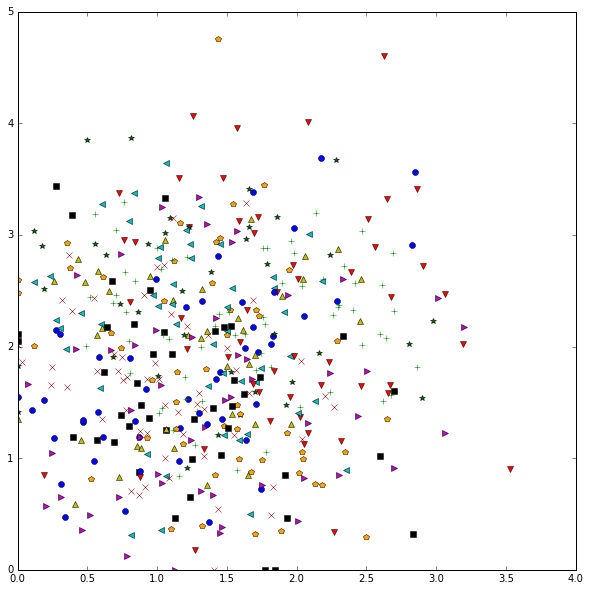

In [6]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

nplot=500 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.figure(figsize=(10, 10))
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
    color=colors[label], marker=markers[label], markersize=6)
    dae_train = encoder.predict(x_train)
    # pca_train = pca.transform(x_train)
    encoded_train = dae_train[:nplot]

In [7]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

dim = 2

pca = PCA(n_components=dim)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
pca_decoded = pca.inverse_transform(pca_test)
error = error_reconstruccion(x_test, pca_decoded)
print "Representacion para d'=%.d" + str(dim)
print "Porcentaje de compresion: " + str(float(dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)
print ''


Representacion para d'=%.d2
Porcentaje de compresion: 0.255102040816 %
Error de reconstruccion: 0.00609895649897



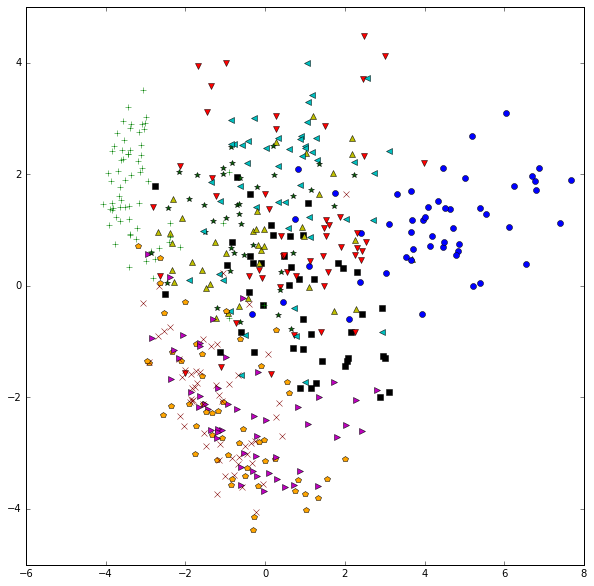

In [8]:

from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

nplot=500 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.figure(figsize=(10, 10))
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
    color=colors[label], marker=markers[label], markersize=6)
    pca_train = pca.transform(x_train)
    encoded_train = pca_train[:nplot]


(i) Construya una función que permita visualizar algunos de los pesos aprendidos por las neuronas de la primera capa del autoencoder. Muestre el resultado para las mejores redes conseguidas en los ítems anteriores.

(j) Estudie como cambian los resultados del modelo construido en (a) si se impone simetría, es decir, si se trabaja con *tied weights*.

### 1.2 Denoising

Como hemos discutido en clases, un *denoising autoencoder* (dAE) es esencialmente un *autoencoder* entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modidicación simple es posible obtener representaciones latentes más robustas y significativas que aquellas obtenidas por un AE basico. En esta sección exploraremos la aplicación más "natural" o "directa" del método.

(a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $\textbf{x} \in \mathbb{R}^d$ es una de las imágenes originales, la versión ruidosa $\tilde{\textbf{x}}$ se obtiene
como $\tilde{\textbf{x}} = \textbf{x} \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in \mathbb{R}^d$ es un vector aleatorio binario con componentes $\text{Ber}(p)$ independientes.

In [84]:
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

(b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ítem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de $p$ en el rango $(0, 1)$.

Se realiza a continuación el entrenamiento de deep AE con niveles de ruido 0.1 y 0.4. Cabe señalar que 0.1 y 0.4 representan la probabilidad de no cubrir un pixel, por lo que en realidad 0.1 es un nivel de ruido mayor que 0.4, en este contexto. El entrenamiento se realiza con imágenes con ruido, aunque la pérdida para ajustar gradiente se obtiene comparando contra la imagen original. En orden a demostrar que este deep AE puede reconstruir las imágenes corruptas, a las imágenes de testing también se les aplicó ruido. La inspección de las imágenes restauradas da cuenta de que la red es exitosa en esta tarea, lo que probablemente se debe a que se optó por un deep AE. 

In [22]:

target_dim = 16 
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
autoencoder.save('denoise_768x1000x500x250x16.h5')
decoded_test = autoencoder.predict(x_test)
error = error_reconstruccion(x_test, decoded_test)
print "deep AE de 4 capas y 16 dimensiones"
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)


deep AE de 4 capas y 16 dimensiones
Porcentaje de compresion: 2.04081632653 %
Error de reconstruccion: 0.00399477158726


(10000, 64)
Reconstruccion para d'=64


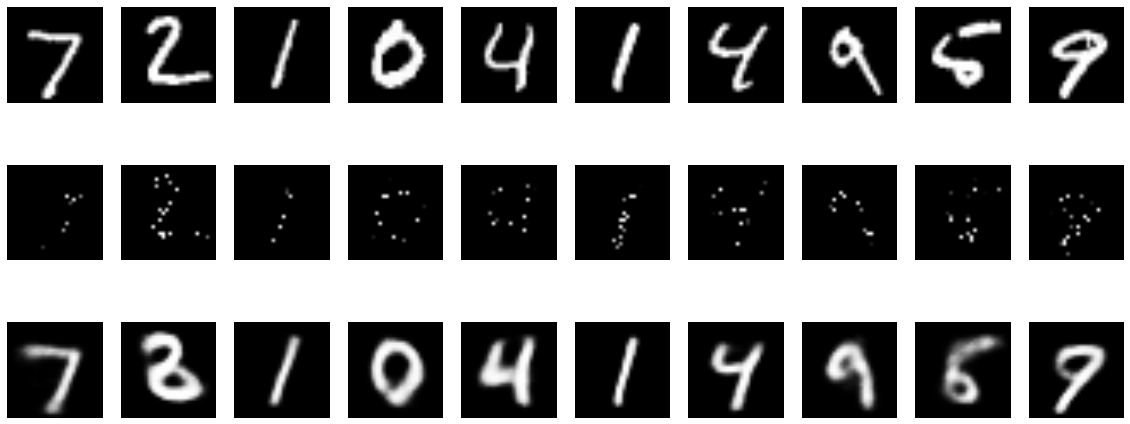

In [23]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

decoded_test = autoencoder.predict(noisy_x_test)
print(encoded_test.shape)

# plots
n = 10
plt.figure(figsize=(20, 8))
    
print "Reconstruccion para d'=" + str(dim[j])
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
    
 

In [5]:
from numpy.random import binomial
noise_level = 0.4
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

In [8]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

target_dim = 16 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
autoencoder.save('denoise_768x1000x500x250x16v1_2.h5')
decoded_test = autoencoder.predict(x_test)
error = error_reconstruccion(x_test, decoded_test)
print "deep AE de 4 capas y 16 dimensiones" + str(target_dim)
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)

deep AE de 4 capas y 16 dimensiones16
Porcentaje de compresion: 2.04081632653 %
Error de reconstruccion: 0.0029755281837


Reconstruccion para d'=16


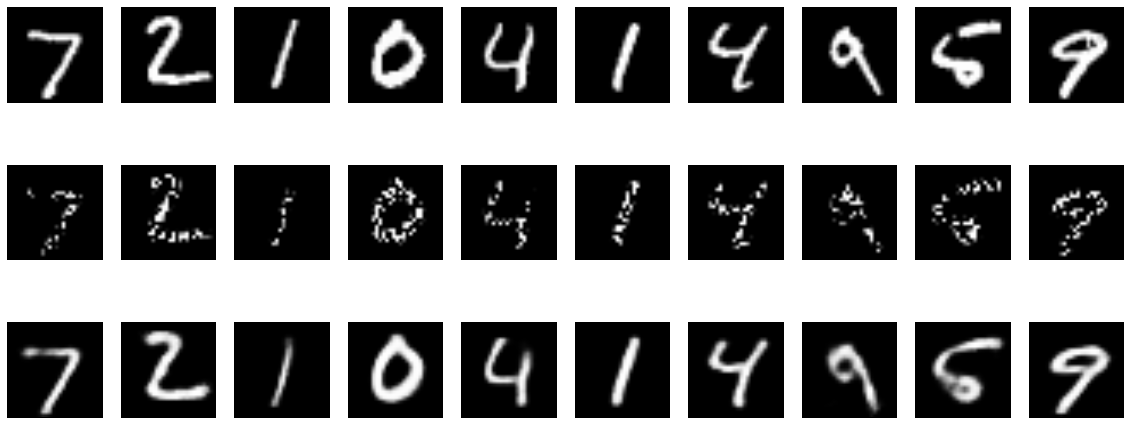

In [11]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

decoded_test = autoencoder.predict(noisy_x_test)


# plots
n = 10
plt.figure(figsize=(20, 8))
    
print "Reconstruccion para d'=" + str(target_dim)
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(c) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (Gaussian noise): si $\textbf{x} \in \mathbb{R}^d$ es una de las imágenes originales, la versión ruidosa $\tilde{\textbf{x}}$ se obtiene
como $\tilde{\textbf{x}} = \textbf{x}+\xi$ donde $\xi \in \mathbb{R}^d$ es un vector aleatorio binario con componentes $\mathcal{N}(0, \sigma^2)$ independientes.

In [12]:
from numpy.random import standard_normal
devst = 0.5
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test*noise_mask

(d) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ítem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de $\sigma$.

Se repite el experimento anterior, esta vez con ruido gaussiano, con desviaciones de 0.5 y 0.8. En ambos casos se replica los buenos resultados obtenidos previamente con máscara de ruido. 

In [13]:
target_dim = 16 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
autoencoder.save('denoise_768x1000x500x250x16v3.h5')
decoded_test = autoencoder.predict(x_test)
error = error_reconstruccion(x_test, decoded_test)
print "deep AE de 4 capas y 16 dimensiones" 
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)

deep AE de 4 capas y 16 dimensiones
Porcentaje de compresion: 2.04081632653 %
Error de reconstruccion: 0.00657783820948


Reconstruccion para d'=16


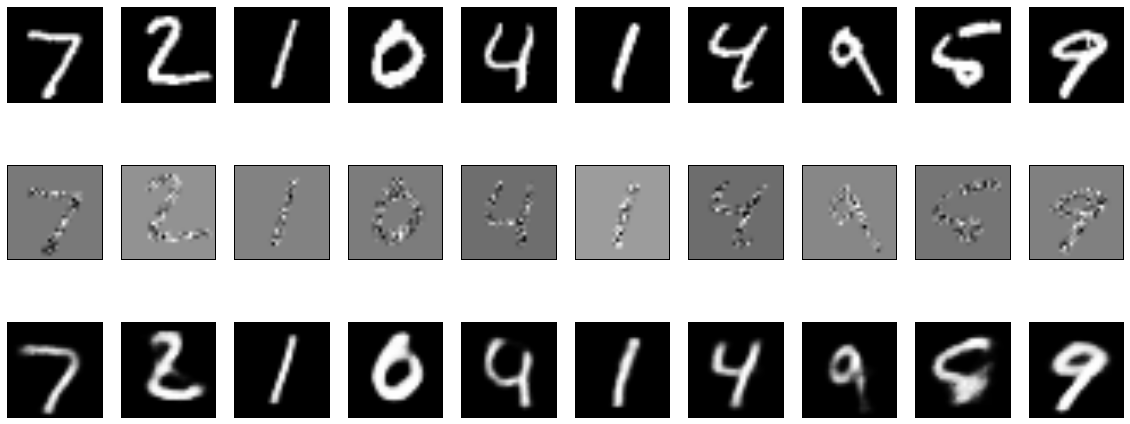

In [14]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

decoded_test = autoencoder.predict(noisy_x_test)

# plots
n = 10
plt.figure(figsize=(20, 8))
    
print "Reconstruccion para d'=" + str(target_dim)
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Se repite el experimento con σ = 0.8

In [15]:
from numpy.random import standard_normal
devst = 0.8
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test*noise_mask

In [17]:
target_dim = 16 
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
autoencoder.save('denoise_768x1000x500x250x16v4.h5')
decoded_test = autoencoder.predict(x_test)
error = error_reconstruccion(x_test, decoded_test)
print "deep AE de 4 capas y 16 dimensiones" 
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)

deep AE de 4 capas y 16 dimensiones
Porcentaje de compresion: 2.04081632653 %
Error de reconstruccion: 0.0030764967346


Reconstruccion para d'=16


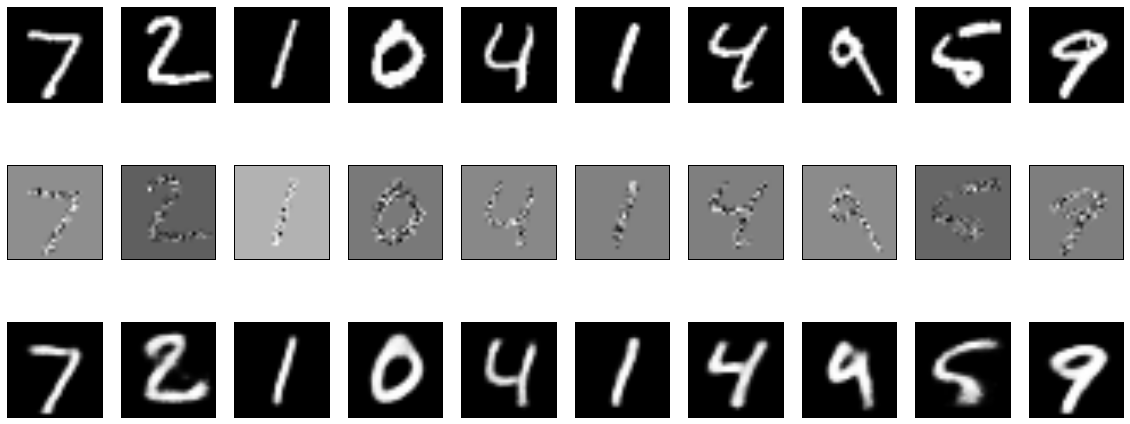

In [20]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

decoded_test = autoencoder.predict(noisy_x_test)

# plots
n = 10
plt.figure(figsize=(20, 8))
    
print "Reconstruccion para d'=" + str(target_dim)
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(e) Escriba una función que permita visualizar los pesos aprendidos por el dAE y compárelos con aquellos aprendidos por un AE ordinario. ¿Observa diferencias?

Se observará en primer lugar los pesos generados por un AE de 64 dimensiones ocultas, en su versión con función de activación Sigmoid y ReLU, entrenado sin ruido. Se visualizará la representación obtenida en la capa oculta. No se ha considerado los bias, los que no son relevantes dado que no alteran las formas y patrones a detectar.  A continuación se experimenta con AE y dAE, ambos simples de una capa oculta de 8 dimensiones, en sus versiones sigmoid y ReLu. Se utiliza un nivel de ruido moderado (noise_level = 0.6).

En general se aprecia que se logra visualizar los eventuales patrones que activarían cada capa oculta. Incluso es posible al menos imaginar las formas de algunos números. Las versiones con activación sigmoid presentan varios nodos que, aparentemente, estarían inactivos dado que no se aprecia patrón alguno. Al agregar ruido la representación de pesos de sigmoid pareciera ganar resolución. Las versiones con activación ReLu hacen uso más amplio de los nodos, no quedando inactivos, y no se aprecia un efecto marcado al implementar la máscara de ruido. 


In [9]:
from numpy.random import binomial
noise_level = 0.6
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

input_img = Input(shape=(784,))

dim = 64

# Model 
encoded = Dense(dim, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, verbose=0,validation_data=(x_val, x_val))
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
scores = autoencoder.evaluate(decoded_test, x_test, verbose=0)
autoencoder.save('basic_autoencoder_768' + str(dim) + '.h5')
error = error_reconstruccion(x_test, decoded_test)
print("basic AE de 64 dimensiones")
print ("Porcentaje de compresion: " + str(float(dim)*100/784) +" %")
print("Error de reconstruccion: " + str(error))


basic AE de 64 dimensiones
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.00213101403969


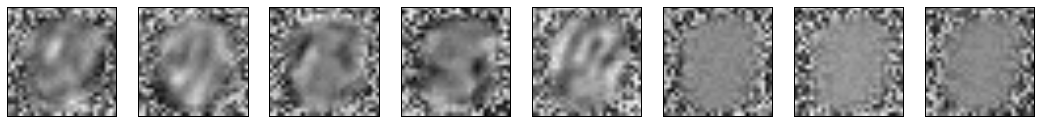

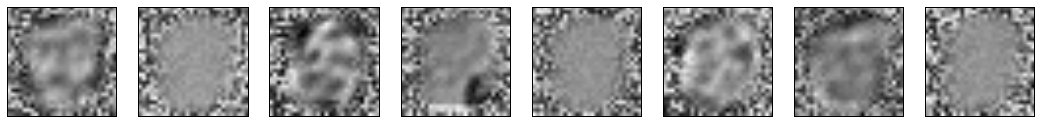

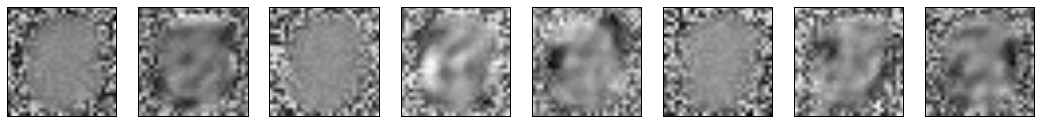

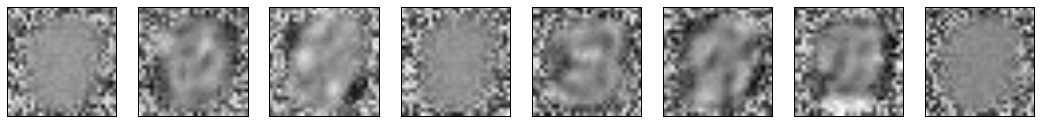

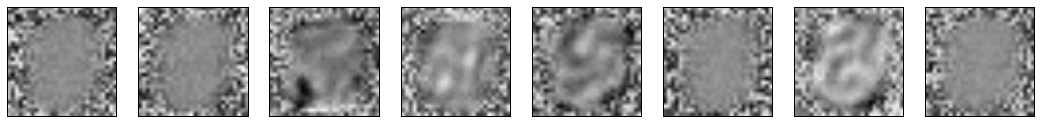

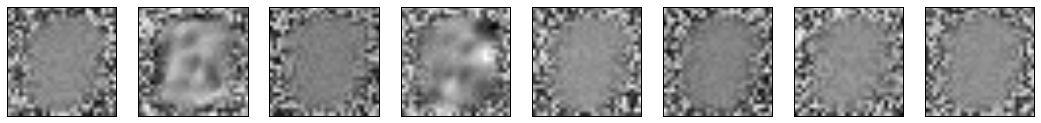

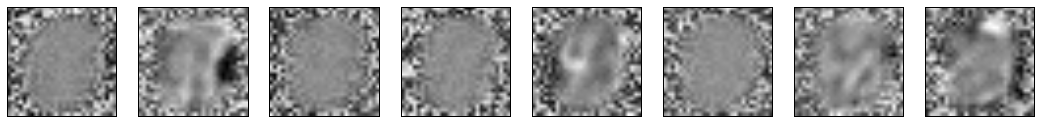

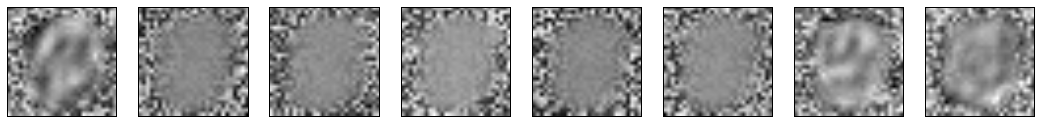

In [11]:
from keras.models import load_model
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline
# Load models
weights = encoder.get_weights()[0]

X = np.zeros(shape=(len(weights[0]),len(weights)))

for i in range(len(weights)):
    for j in range(len(weights[0])):
        X[j,i] = weights[i,j]/(sum(map(lambda x:x*x,weights[i])) )

# plots
n = 64
k=0
for k in range(8):
    plt.figure(figsize=(150, 150))
    for i in range(8*k, 8*k+8):    
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        k = k+1 
    plt.show()

In [12]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation

input_img = Input(shape=(784,))

dim = 64

# Model 
encoded = Dense(dim, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, verbose=0,validation_data=(noisy_x_val, x_val))
encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test)
scores = autoencoder.evaluate(decoded_test, x_test, verbose=0)
autoencoder.save('basic_autoencoder_768_dea' + str(dim) + '.h5')
error = error_reconstruccion(x_test, decoded_test)
print ("dAE de 64 dimensiones")
print ("Porcentaje de compresion: " + str(float(dim)*100/784) +" %")
print( "Error de reconstruccion: " + str(error))



dAE de 64 dimensiones
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.00221654449478


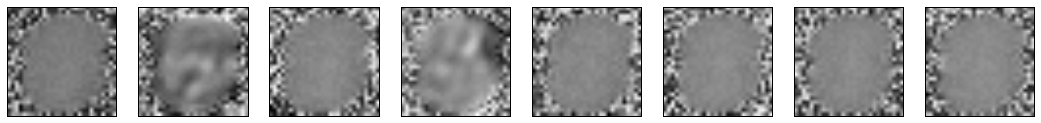

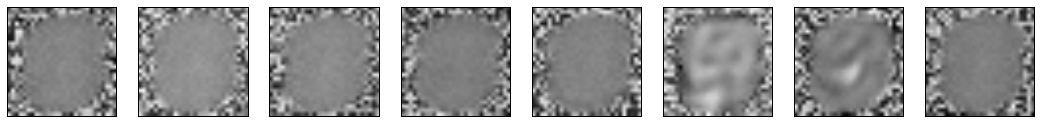

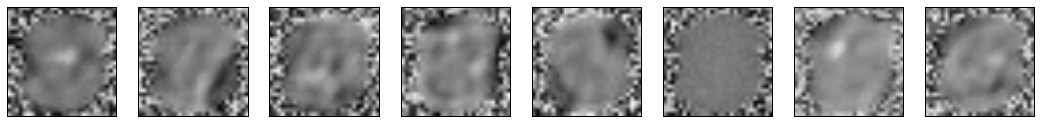

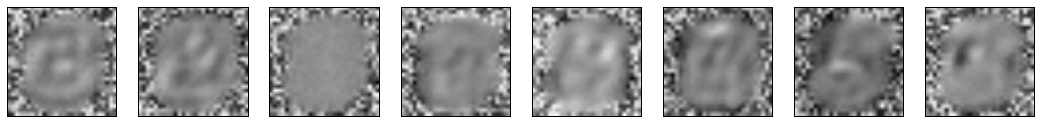

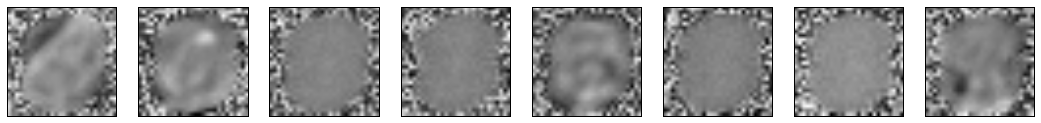

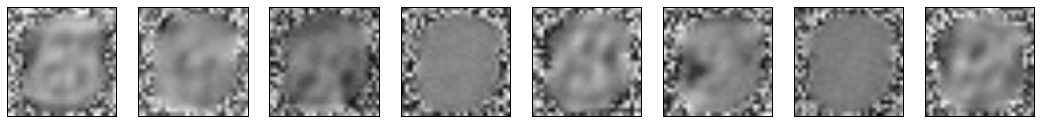

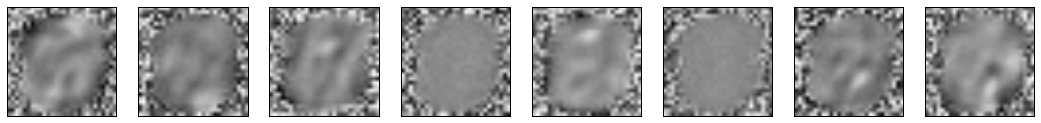

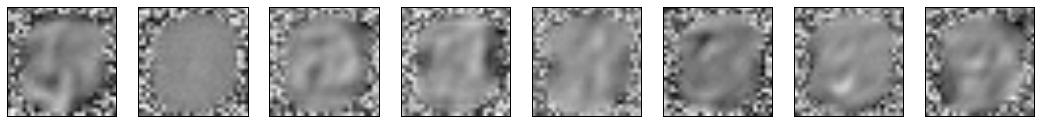

In [13]:
from keras.models import load_model
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline
# Load models
weights = encoder.get_weights()[0]

X = np.zeros(shape=(len(weights[0]),len(weights)))

for i in range(len(weights)):
    for j in range(len(weights[0])):
        X[j,i] = weights[i,j]/(sum(map(lambda x:x*x,weights[i])) )

# plots
n = 64
k=0
for k in range(8):
    plt.figure(figsize=(150, 150))
    for i in range(8*k, 8*k+8):    
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        k = k+1 
    plt.show()

Se repite el experimento con función de activación ReLu.

In [14]:
#IDEM con ReLu

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation

dim = 64

# Model 
encoded = Dense(dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, verbose=0,validation_data=(x_val, x_val))
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
scores = autoencoder.evaluate(decoded_test, x_test, verbose=0)
autoencoder.save('basic_autoencoder_768_25_relu' + str(dim) + '.h5')
error = error_reconstruccion(x_test, decoded_test)
print ("basic AE ReLu de 64 dimensiones")
print ("Porcentaje de compresion: " + str(float(dim)*100/784) +" %")
print ("Error de reconstruccion: " + str(error))



basic AE ReLu de 64 dimensiones
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.000509438136247


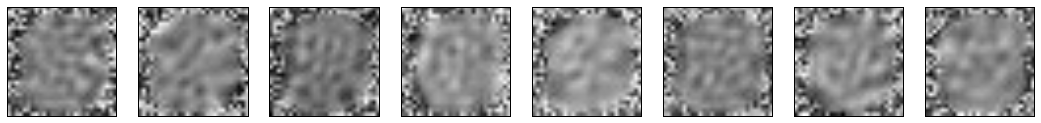

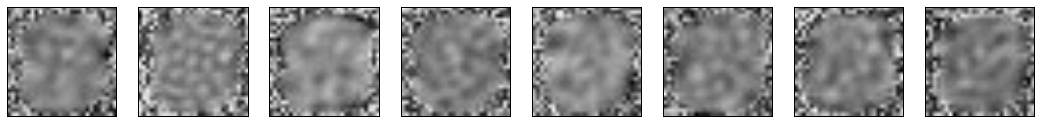

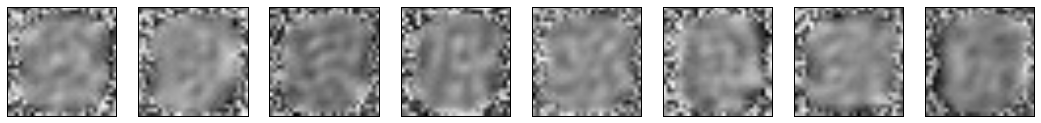

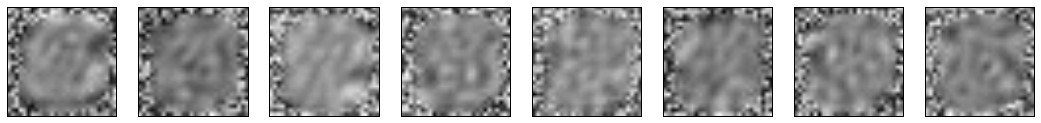

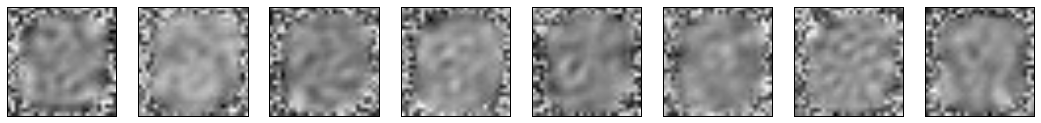

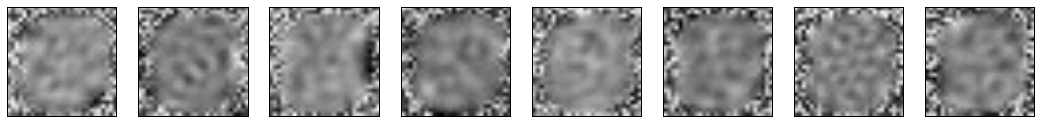

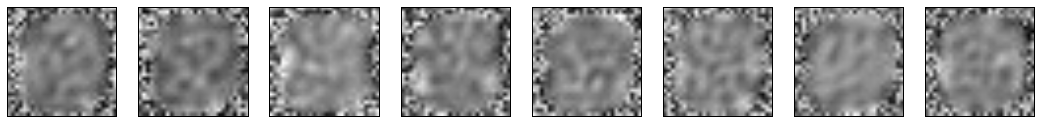

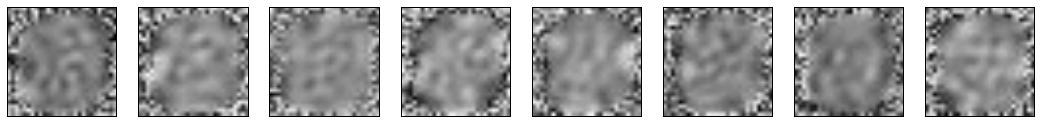

In [15]:
from keras.models import load_model
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline
# Load models
weights = encoder.get_weights()[0]

X = np.zeros(shape=(len(weights[0]),len(weights)))

for i in range(len(weights)):
    for j in range(len(weights[0])):
        X[j,i] = weights[i,j]/(sum(map(lambda x:x*x,weights[i])) )

# plots
n = 64
k=0
for k in range(8):
    plt.figure(figsize=(150, 150))
    for i in range(8*k, 8*k+8):    
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        k = k+1 
    plt.show()

In [16]:
#IDEM con ReLu

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation

dim = 64

# Model 
encoded = Dense(dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, verbose=0,validation_data=(noisy_x_val, x_val))
encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test)
scores = autoencoder.evaluate(decoded_test, x_test, verbose=0)
autoencoder.save('basic_autoencoder_768_dEA_ReLu' + str(dim) + '.h5')
error = error_reconstruccion(x_test, decoded_test)
print ("dAE ReLu de 64 dimensiones")
print ("Porcentaje de compresion: " + str(float(dim)*100/784) +" %")
print ("Error de reconstruccion: " + str(error))


dAE ReLu de 64 dimensiones
Porcentaje de compresion: 8.16326530612 %
Error de reconstruccion: 0.00122907772369


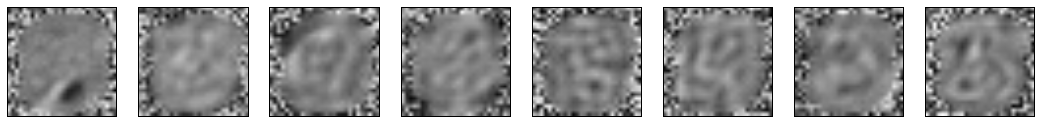

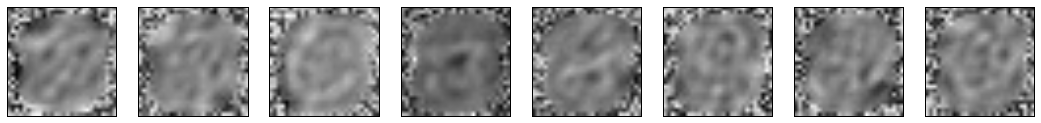

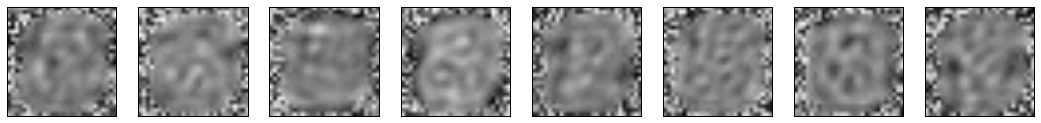

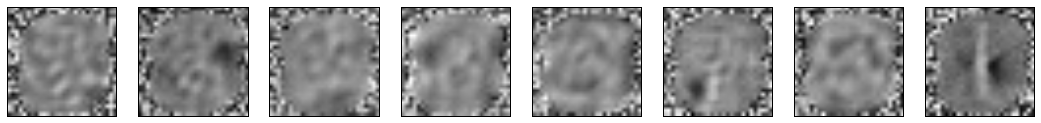

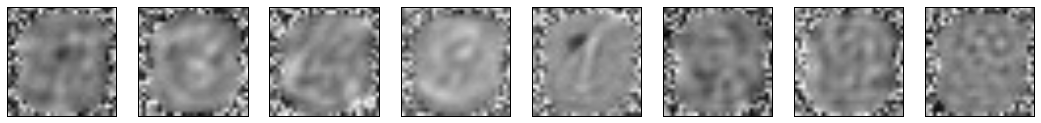

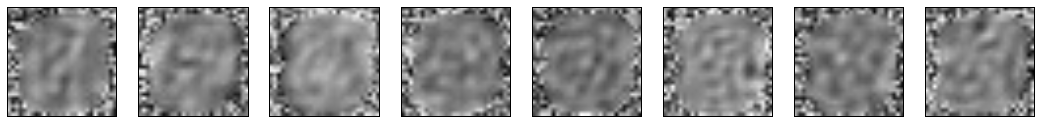

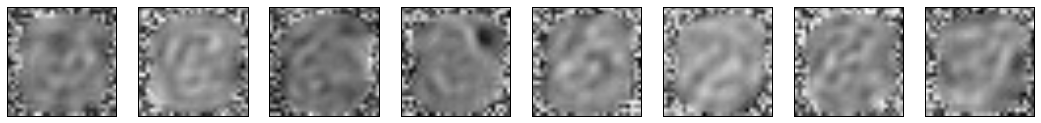

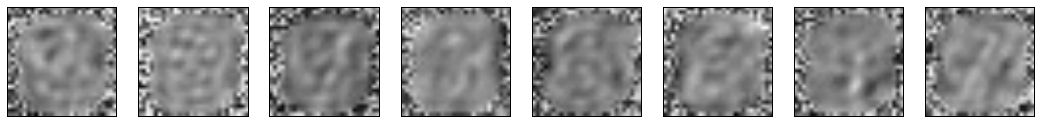

In [17]:
from keras.models import load_model
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline
# Load models
weights = encoder.get_weights()[0]

X = np.zeros(shape=(len(weights[0]),len(weights)))

for i in range(len(weights)):
    for j in range(len(weights[0])):
        X[j,i] = weights[i,j]/(sum(map(lambda x:x*x,weights[i])) )

# plots
n = 64
k=0
for k in range(8):
    plt.figure(figsize=(150, 150))
    for i in range(8*k, 8*k+8):    
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        k = k+1 
    plt.show()

(f) Suponga que su objetivo es aprender una representación de menor dimensionalidad del conjunto de ejemplos. ¿Es posible mejorar los resultados de reconstruccion obtenidos con un AE ordinario entrenándolo con datos artificialmente corruptos? Proyecte un conjunto de experimentos que permita evaluar esta hipótesis. Note que en este caso debe evaluar el AE sobre los datos de prueba no corruptos.

En el siguiente experimento se configura un AE básico de 16 dimensiones en la capa oculta, el cual se entrena en dos ocasiones, sin y con una máscara de ruido. Se evalua los resultados de cada una en términos de error de reconstrucción, clasificación y clustering. 

Por tiempo no se evaluará otras configuraciones de AE ni el efecto de ruido gausiano, pero se puede proyectar un experimento que mida el efecto para más dimensiones, e incluyendo ruido gaussiano. 

In [33]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation
from sklearn.cluster import KMeans
from sklearn import metrics

dim = 16

# Model 
encoded = Dense(dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, verbose=0,validation_data=(x_val, x_val))
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
scores = autoencoder.evaluate(decoded_test, x_test, verbose=0)
autoencoder.save('basic_autoencoder_768_sruido' + str(dim) + '.h5')
error = error_reconstruccion(x_test, decoded_test)
encoded_train = encoder.predict(x_train)
# Clasificador kNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
scorekNN = clf.score(encoded_test,y_test)
# k-means
model = KMeans(n_clusters=10)
labels_pred = model.fit_predict(encoded_train)
scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
print "AE básico sin ruido, 16 dimensiones" 
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)
print 'Classification Accuracy %.2f' % scorekNN 
print 'Clustering ARI %.2f' % scorekMeans
print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
print " "



AE básico sin ruido, 16 dimensiones
Porcentaje de compresion: 2.04081632653 %
Error de reconstruccion: 0.00190949830539
Classification Accuracy 0.96
Clustering ARI 0.24
Clustering ACC 0.49
 


In [34]:
from numpy.random import binomial
noise_level = 0.6
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

In [35]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation

dim = 16

# Model 
encoded = Dense(dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, verbose=0,validation_data=(noisy_x_val, x_val))
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
scores = autoencoder.evaluate(decoded_test, x_test, verbose=0)
autoencoder.save('basic_autoencoder_768_cruido' + str(dim) + '.h5')
error = error_reconstruccion(x_test, decoded_test)
encoded_train = encoder.predict(x_train)
# Clasificador kNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
scorekNN = clf.score(encoded_test,y_test)
# k-means
model = KMeans(n_clusters=10)
labels_pred = model.fit_predict(encoded_train)
scorekMeans = metrics.adjusted_rand_score(y_train, labels_pred)
print "AE básico con ruido, 16 dimensiones" 
print "Porcentaje de compresion: " + str(float(target_dim)*100/784) +" %"
print "Error de reconstruccion: " + str(error)
print 'Classification Accuracy %.2f' % scorekNN 
print 'Clustering ARI %.2f' % scorekMeans
print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
print " "

AE básico con ruido, 16 dimensiones
Porcentaje de compresion: 2.04081632653 %
Error de reconstruccion: 0.00277672497626
Classification Accuracy 0.96
Clustering ARI 0.27
Clustering ACC 0.51
 


### 1.3 Pre-entrenamiento

En esta sección utilizaremos los modelos de las secciones anteriores (autoencoders y RBMs) para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

(a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice BP sin ningún tipo de pre-entrenamiento. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y funciones de activación sigmoidales. Determine la *accuracy* (fracción de clasificaciones correctas) alcanzada por el modelo en el conjunto de test.

In [58]:
clasificacion = [] # Almacena clasificaciones
clasificacion = np.append(clasificacion, y_test)
print clasificacion

[ 7.  2.  1. ...,  4.  5.  6.]


Se construye a continuación una Red FF de acuerdo a las especificaciones solicitadas. Por razones de capacidad y tiempo de procesamiento se ha reducido el entrenamiento a sólo 10 épocas (de las 50 originales), lo cual se mantendrá fijo para todos los entrenamientos en esta sección, incluido preentrenamiento y fine tunning. Se presenta evaluación de resultados en términos de Acuracy y se observa la clasificación obtenida para algunas imágenes. 

Esta primera Red FF logró sobre el 90% de éxito en la clasificación, lo que se ve reflejado en los 10 primeros casos visualizados. Mirando la imágen de el primer error, no es sorprendente que la red pudiera tomar el "5" por un "6". 

In [59]:
from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import np_utils

input_img = Input(shape=(784,))

n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'sigmoid'
decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=0.05)
epochs_ = 10                  ###### OJO: VOLVER A 50
batch_size_ = 25

## Load and preprocess MNIST as usual
from keras.datasets import mnist

## HERE YOU NEED: Y_train,Y_val,Y_test produced in 1(a)

from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=epochs_, batch_size=25,shuffle=True, validation_data=(x_val, Y_val), verbose=0)
#model.save(ReluNet768x1000x1000x10-NFT50epochs.h5) #USEFUL WHEN TRAINING IS SLOW
#TRAINING CAN THEN BE RESUMED FROM THIS POINT :-)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_97 (Dense)                 (None, 1000)          785000      dense_input_7[0][0]              
____________________________________________________________________________________________________
dense_98 (Dense)                 (None, 1000)          1001000     dense_97[0][0]                   
____________________________________________________________________________________________________
dense_99 (Dense)                 (None, 10)            10010       dense_98[0][0]                   
Total params: 1796010
____________________________________________________________________________________________________


In [60]:
from __future__ import division
pred_test = model.predict(x_test)
pred = np.zeros(len(pred_test))
for l in range(len(pred_test)):
    m = max(pred_test[l])
    pred[l] = ([i for i, j in enumerate(pred_test[l]) if j == m][0])

clasificacion = np.append(clasificacion, pred)
acu = 1- float(np.count_nonzero((pred) - (y_test))/len(pred_test))
print 'Accuracy: '+ str(acu*100) +' %'

Accuracy: 90.18 %


Clasificación ANN


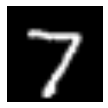

7.0


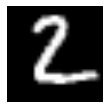

2.0


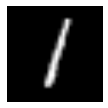

1.0


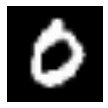

0.0


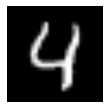

4.0


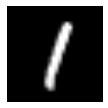

1.0


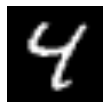

4.0


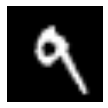

9.0


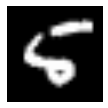

6.0


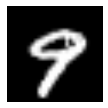

9.0


In [61]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


# plots
n = 10

import operator

print "Clasificación ANN"

i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 1
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 2
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 3
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 4
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 5
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 6
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 7
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 8
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 9
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

(b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no-supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*finetunning*). Compare los resultados de
clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *finetunning*. Comente.

El incorporar preentrenamiento con dos autoencoders, uno por capa, no generé un incremento en la exactitud medida, que incluso bajó levemente. 

In [62]:
## Load and preprocess MNIST as usual
from keras.datasets import mnist

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_, shuffle=True, validation_data=(x_val, x_val), verbose=0)
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1), verbose=0)
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=epochs_, batch_size=25,
          shuffle=True, validation_data=(x_val, Y_val), verbose=0)
#model.save('Net-768x1000x1000x10-finetunned.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_104 (Dense)                (None, 1000)          785000      dense_input_8[0][0]              
____________________________________________________________________________________________________
dense_105 (Dense)                (None, 1000)          1001000     dense_104[0][0]                  
____________________________________________________________________________________________________
dense_106 (Dense)                (None, 10)            10010       dense_105[0][0]                  
Total params: 1796010
____________________________________________________________________________________________________


In [63]:
from __future__ import division
pred_test = model.predict(x_test)
pred = np.zeros(len(pred_test))
for l in range(len(pred_test)):
    m = max(pred_test[l])
    pred[l] = ([i for i, j in enumerate(pred_test[l]) if j == m][0])

clasificacion = np.append(clasificacion, pred)
acu = 1- float(np.count_nonzero((pred) - (y_test))/len(pred_test))
print 'Accuracy: '+ str(acu*100) +' %'

Accuracy: 90.04 %


Clasificación ANN


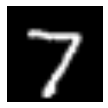

7.0


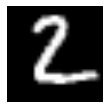

2.0


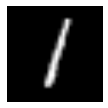

1.0


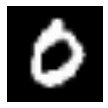

0.0


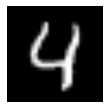

4.0


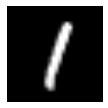

1.0


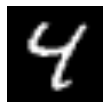

4.0


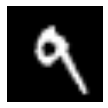

9.0


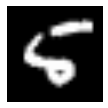

6.0


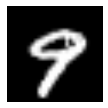

9.0


In [64]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


# plots
n = 10

import operator

print "Clasificación ANN"

i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 1
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 2
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 3
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 4
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 5
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 6
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 7
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 8
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 9
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

(c) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante una RBM binaria básica. Compare los resultados con aquellos obtenidos en (a) y (b). Comente.

A diferencia del caso anterior con preentrenamiento basado en AE simples, con preentrenamiento con RBM sí se logra un aumento significativo de la exactitud, que casi llega a 96%. Incluso el esquívo "5" logra ser correctamente identificado. Cabe señalar que no seha realizado mayor configuración, más allá de definir learning rate de 0.05 en ls RBM, por lo que se puede esperar que este resultado es todavía mejorable. 

In [66]:
from sklearn.neural_network import BernoulliRBM
rbm1 = BernoulliRBM(n_components=n_hidden_layer1, batch_size=25,
learning_rate=0.05,verbose=0, n_iter=epochs_)
rbm1.fit(x_train)##Train using persistent Gibbs chains
encoded_train1 = rbm1.transform(x_train)
encoded_val1 = rbm1.transform(x_val)
encoded_test1 = rbm1.transform(x_test)

rbm2 = BernoulliRBM(n_components=n_hidden_layer2, batch_size=25,
                    learning_rate=0.05,verbose=0, n_iter=epochs_)
rbm2.fit(encoded_train1)
encoded_train2 = rbm2.transform(encoded_train1)
encoded_val2 = rbm2.transform(encoded_val1)
encoded_test2 = rbm2.transform(encoded_test1)

weights1 = np.transpose(rbm1.components_) ##### pesos capa1
bias1 = rbm1.intercept_hidden_
w1 = [weights1 , bias1]

weights2 = np.transpose(rbm2.components_) ##### pesos capa2
bias2 = rbm2.intercept_hidden_
w2 = [weights2 , bias2]

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(w1)
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(w2)
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=epochs_, batch_size=25,
          shuffle=True, validation_data=(x_val, Y_val), verbose=0)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_107 (Dense)                (None, 1000)          785000      dense_input_9[0][0]              
____________________________________________________________________________________________________
dense_108 (Dense)                (None, 1000)          1001000     dense_107[0][0]                  
____________________________________________________________________________________________________
dense_109 (Dense)                (None, 10)            10010       dense_108[0][0]                  
Total params: 1796010
____________________________________________________________________________________________________


In [67]:
from __future__ import division
pred_test = model.predict(x_test)
pred = np.zeros(len(pred_test))
for l in range(len(pred_test)):
    m = max(pred_test[l])
    pred[l] = ([i for i, j in enumerate(pred_test[l]) if j == m][0])

clasificacion = np.append(clasificacion, pred)
acu = 1- float(np.count_nonzero((pred) - (y_test))/len(pred_test))
print 'Accuracy: '+ str(acu*100) +' %'

Accuracy: 95.98 %


Clasificación ANN


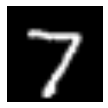

7.0


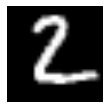

2.0


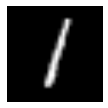

1.0


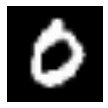

0.0


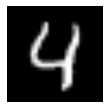

4.0


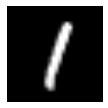

1.0


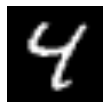

4.0


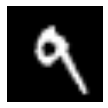

9.0


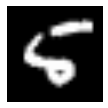

5.0


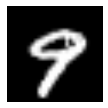

9.0


In [68]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


# plots
n = 10

import operator

print "Clasificación ANN"

i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 1
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 2
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 3
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 4
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 5
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 6
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 7
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 8
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 9
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

(d) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un denoising autoencoder. Compare los resultados con aquellos obtenidos en (a), (b) y (c). Comente.

Pese a que el efecto es bajo, al incluir ruido en el entrenamiento de los autoencoders se lográ recuperar la eficiencia perdida con la incorporación de los AE, quedando la exactitud de clasificación levemente mejor que respecto a la Red FF sin ningún agregado. Sin embargo, se insiste en que la diferencia observada es demasiado baja para declarar un efecto significativo. No se ha logrado la eficacia obtenida con entrenamiento RBM. 

In [70]:
epochs_ = 10 ######### VOLVER A 50

## Load and preprocess MNIST as usual
from keras.datasets import mnist

from numpy.random import binomial
noise_level = 0.6
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask

## Load and preprocess MNIST as usual
from keras.datasets import mnist

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(noisy_x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
noise_mask = binomial(n=1,p=noise_level,size=x_train_encoded1.shape)
noisy_x_train = x_train_encoded1*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val_encoded1.shape)
noisy_x_val = x_val_encoded1*noise_mask

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1), verbose=0)
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=epochs_, batch_size=25,
          shuffle=True, validation_data=(x_val, Y_val), verbose=0)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_116 (Dense)                (None, 1000)          785000      dense_input_10[0][0]             
____________________________________________________________________________________________________
dense_117 (Dense)                (None, 1000)          1001000     dense_116[0][0]                  
____________________________________________________________________________________________________
dense_118 (Dense)                (None, 10)            10010       dense_117[0][0]                  
Total params: 1796010
____________________________________________________________________________________________________


In [71]:
from __future__ import division
pred_test = model.predict(x_test)
pred = np.zeros(len(pred_test))
for l in range(len(pred_test)):
    m = max(pred_test[l])
    pred[l] = ([i for i, j in enumerate(pred_test[l]) if j == m][0])

clasificacion = np.append(clasificacion, pred)
acu = 1- float(np.count_nonzero((pred) - (y_test))/len(pred_test))
print 'Accuracy: '+ str(acu*100) +' %'

Accuracy: 90.22 %


Clasificación ANN


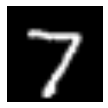

7.0


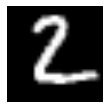

2.0


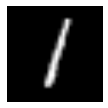

1.0


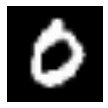

0.0


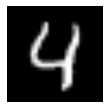

4.0


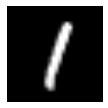

1.0


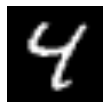

4.0


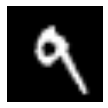

9.0


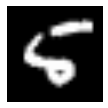

6.0


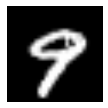

9.0


In [72]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


# plots
n = 10

import operator

print "Clasificación ANN"

i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 1
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 2
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 3
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 4
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 5
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 6
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 7
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 8
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 9
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

(e) Evalúe el efecto de incorporar un regularizador $l_2$ y/o $l_1$ (elija usted) al entrenamiento de la red neuronal final. Comente.

Por razones de tiempo y capacidad de cómputo se optó por evaluar regularización solamente para la última configuración probada (d). Se utiliza regularización basada en norma l2 en consideración a que es esperable que sea más eficiente computacionalmente, lo cual ha sido una restricción importante durante la presente tarea. 

Se observa que la incoroporación de regularización resulta fatal para el modelo predictivo, que pierde todas sus propiedades. El 10% de exactitud es sólo producto de clasificar siempre la misma clase, y no es mejor de lo que se obtendría con clasificación aleatoria. 

In [74]:
epochs_ = 10 ######### VOLVER A 50

## Load and preprocess MNIST as usual
from keras.datasets import mnist

from numpy.random import binomial
noise_level = 0.6
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask

## Load and preprocess MNIST as usual
from keras.datasets import mnist

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(noisy_x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
noise_mask = binomial(n=1,p=noise_level,size=x_train_encoded1.shape)
noisy_x_train = x_train_encoded1*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val_encoded1.shape)
noisy_x_val = x_val_encoded1*noise_mask

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1), verbose=0)
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')

#FINE TUNNING
from keras.models import Sequential
from keras.regularizers import l2, activity_l2
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, W_regularizer=l2(0.01), input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2, W_regularizer=l2(0.01)))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=epochs_, batch_size=25,
          shuffle=True, validation_data=(x_val, Y_val), verbose=0)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_130 (Dense)                (None, 1000)          785000      dense_input_12[0][0]             
____________________________________________________________________________________________________
dense_131 (Dense)                (None, 1000)          1001000     dense_130[0][0]                  
____________________________________________________________________________________________________
dense_132 (Dense)                (None, 10)            10010       dense_131[0][0]                  
Total params: 1796010
____________________________________________________________________________________________________


In [75]:
from __future__ import division
pred_test = model.predict(x_test)
pred = np.zeros(len(pred_test))
for l in range(len(pred_test)):
    m = max(pred_test[l])
    pred[l] = ([i for i, j in enumerate(pred_test[l]) if j == m][0])

clasificacion = np.append(clasificacion, pred)
acu = 1- float(np.count_nonzero((pred) - (y_test))/len(pred_test))
print 'Accuracy: '+ str(acu*100) +' %'

Accuracy: 9.82 %


Clasificación ANN


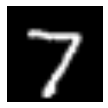

4.0


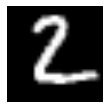

4.0


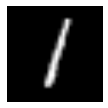

4.0


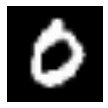

4.0


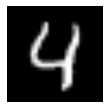

4.0


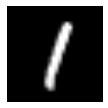

4.0


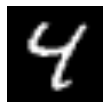

4.0


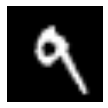

4.0


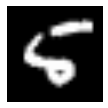

4.0


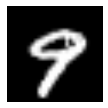

4.0


In [76]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


# plots
n = 10

import operator

print "Clasificación ANN"

i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 1
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 2
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 3
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 4
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 5
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 6
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 7
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 8
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 9
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

(f) $\star$ Repita los experimentos (a)-(d) utilizando funciones de activación $Tanh$ y $ReLu$. Comente.

Se repite el experimento anterior una vez más, esta vez usando activación ReLu en los autoencoder y Red FF (excepto capa de Decoder). No fue posible realizar más experimentos con esta configuración, pero se aprecia que en este caso la regularización no perjudicó la capacidad predictiva, que con 94% se acerca bastante al mejor resultado, obtenido con preentrenamiento RBM.

In [79]:
## PARAMETERS ...
n_hidden_layer1 = 1000
activation_layer1 = 'relu'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer1 = 'relu'
decoder_activation_2 = 'sigmoid'

In [80]:
epochs_ = 10 ######### VOLVER A 50

## Load and preprocess MNIST as usual
from keras.datasets import mnist

from numpy.random import binomial
noise_level = 0.6
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask

## Load and preprocess MNIST as usual
from keras.datasets import mnist

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(noisy_x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_, shuffle=True, validation_data=(noisy_x_val, x_val), verbose=0)
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
noise_mask = binomial(n=1,p=noise_level,size=x_train_encoded1.shape)
noisy_x_train = x_train_encoded1*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val_encoded1.shape)
noisy_x_val = x_val_encoded1*noise_mask

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1), verbose=0)
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=epochs_, batch_size=25,
          shuffle=True, validation_data=(x_val, Y_val), verbose=0)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_139 (Dense)                (None, 1000)          785000      dense_input_13[0][0]             
____________________________________________________________________________________________________
dense_140 (Dense)                (None, 1000)          1001000     dense_139[0][0]                  
____________________________________________________________________________________________________
dense_141 (Dense)                (None, 10)            10010       dense_140[0][0]                  
Total params: 1796010
____________________________________________________________________________________________________


In [81]:
from __future__ import division
pred_test = model.predict(x_test)
pred = np.zeros(len(pred_test))
for l in range(len(pred_test)):
    m = max(pred_test[l])
    pred[l] = ([i for i, j in enumerate(pred_test[l]) if j == m][0])

clasificacion = np.append(clasificacion, pred)
acu = 1- float(np.count_nonzero((pred) - (y_test))/len(pred_test))
print 'Accuracy: '+ str(acu*100) +' %'

Accuracy: 94.12 %


Clasificación ANN


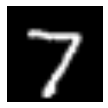

7.0


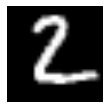

2.0


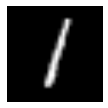

1.0


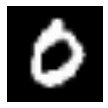

0.0


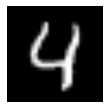

4.0


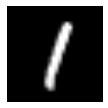

1.0


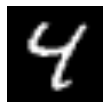

4.0


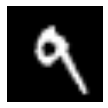

9.0


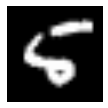

6.0


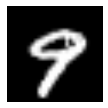

9.0


In [82]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


# plots
n = 10

import operator

print "Clasificación ANN"

i = 0
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 1
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 2
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 3
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 4
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 5
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 6
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 7
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 8
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

i = 9
plt.figure(figsize=(20, 4))
ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test[i].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
plt.show()
m = max(decoded_test[i])
print pred[i]

(g) $\star\star$ Evalúe el efecto de cambiar el número de neuronas ocultas en cada capa del modelo. Por simplicidad y aún si no es la arquitectura óptima para este problema puede fijar el número de capas ocultas a $L = 3$ y experimente, al menos, con un número de neuronas igual a $500, 1000, 2000, 4000$.

(h) $\star\star$ Evalúe el efecto de aumentar la profundidad de $1, 2, 3$ niveles en el modelo. Por simplicidad y aún si no es la arquitectura óptima para este problema mantenga fijo el número de neuronas ocultas.

CONCLUSIÓN PREGUNTA 1

Se ha explorado el uso de Autoencoders principalmente, pero también PCA y RBM, en funciones relativas a: reducción de dimensionalidad, eliminación de ruido y preentrenamiento de redes profundas. 

Se constata que los AE logran efectivamente construir representaciones de dimensionalidad reducida, con resultados iguales o mejores que PCA y RBM (Bernoulli). Sobre todo respecto a RBM resultan también más eficientes. Quizá su mayor ventaja es que les permite aprovechar una arquitectura profunda, lo que logra garantizar buenos resultados. 

Se ha confirmado que son una herramienta adecuada para mitigar efectos de ruido y distorción en imágenes, lo cual además puede aportar robustez a los modelos obtenidos. Este efecto, si bien menor, logra impactar en el uso de los AE como heramienta de pre-entrenamiento de Redes FF. Para esta función, sin embargo, los mejores resultados observados en la presente tarea se han logrado pre-entrenando con Bernoulli RBM. 




## Referencias

* [1] Hastie, T.; Tibshirani, R., Friedman, J. (2009), The Elements of Statistical Learning, Second Edition. Springer New York Inc.
* [2] Bishop, Christopher M. (1995). Neural Networks for Pattern Recognition, Clarendon Press.
* [3] Krizhevsky, A., Hinton, G. (2009). Learning multiple layers of features from tiny images.
* [4] Harrison, D. and Rubinfeld, D. (1978). Hedonic prices and the demand for clean air, Journal of Environmental Economics and Management, 5, 81-102
* [5] Dalal, N., Triggs, B. (2005, June). Histograms of oriented gradients for human detection. In 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05) (Vol. 1, pp.886-893). IEEE.
* [6] Forsyth, D. A., Ponce, J. (2002). Computer vision: a modern approach. Prentice Hall Professional Technical Reference.
* [7] Yann LeCun, Leon Bottou, Yoshua Bengio, Patrick Haffner. (1998). Gradient-based Learning Applied to Document Recognition. Proceedings of the IEEE, 86(11), 2278-2324.
* [8] Kunihiko Fukushima, Sei Miyake, Takayuki Ito. Neocognitron: A neural network model for a mechanism of visual pattern recognition. IEEE Transactions on Systems, Man, and Cybernetics 5 (1983): 826-834.
* [9] Yann LeCun, Fu Jie Huang, and Leon Bottou. Learning methods for generic object recognition with invariance to pose and lighting. Proceedings of the 2004 Computer Vision and Pattern Recognition Conference. CVPR 2004. IEEE Computer Society, 2004.
* [10] Xavier Glorot, Antoine Bordes, and Yoshua Bengio. Deep Sparse Rectifier Neural Networks. International Conference on Artificial Intelligence and Statistics. 2011.
* [11] Pierre Sermanet, Soumith Chintala, and Yann LeCun. Convolutional neural networks applied to house numbers digit classification. International Conference on Pattern Recognition (ICPR), 2012. IEEE, 2012
* [12] Scikit-learn: Machine Learning in Python. http://scikit-learn.org/stable/